## Creating a dataframe with coordinates, raster values and region from a shapefile

In [2]:
## Function to get raster pixel coordinates, values, and region names from a shapefile
## Usage: result <- get_raster_coordinates_and_regions(raster_data, shapefile_data)
## where 'raster_data'  and 'shapefile_data', both have the same crs.
## The column names in the resulting data frame are based on the shapefile's column names which can be viewed with head(shapefile_data).
get_raster_coordinates_and_regions <- function(raster_data, shapefile_data) {
  
  # Convert raster data to sf point dataframe with longitude and latitude
  raster_points <- rasterToPoints(raster_data) %>% data.frame() 
  
  raster_points_sp <- st_as_sf(raster_points, coords = c("x", "y"), crs = st_crs(shapefile_data)) %>% as("Spatial")

  # Find corresponding region for each point
  points_regions <- sp::over(raster_points_sp, shapefile_data)

  # Add coordinates, values, and NAMES to the data frame
  result_df <- points_regions %>% 
    select(NAME_1, NAME_2, NAME_3) %>% # Adjust the column names as per the shape file
    mutate(longitude = raster_points[,1], latitude = raster_points[,2], values = raster_points[,3])


  return(result_df)
}


In [4]:
#+++FUNCTION USAGE+++

# Load necessary libraries
library(raster)
library(sf)
library(geodata)
library(tidyverse)
library(sp)

## Load the data
* Raster data - Eg prevalence map, environmental variable maps etc.
* Shapefile - Eg. polygon of a country, region, district etc.

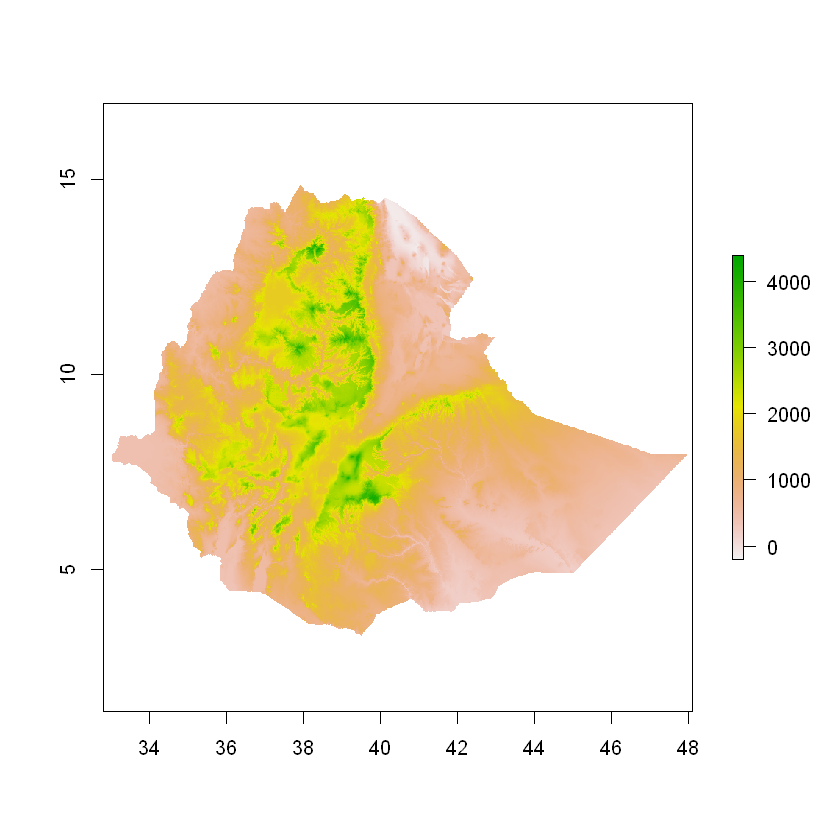

In [22]:
# Set the directory for data
output_dir <- "data/"

# Load raster data
elevation_ETH <- elevation_30s(country = "ETH", path = output_dir)

elevation_ETH_raster <- raster(elevation_ETH)

# Load shapefile data
ethiopia_boundary <- gadm("ETH", level = 3, path = output_dir) %>% st_as_sf() %>% as("Spatial") 

plot(elevation_ETH_raster)

In [13]:
# Example usage of the function with the provided inputs
raster_data <-  elevation_ETH_raster # Replace with your raster file
shapefile_data <- ethiopia_boundary      # Replace with your shapefile

# Check if the crs of both the files are same
# crs(raster_data) 
# crs(shapefile_data)

# Should be inspected manually because the logical operator "==" does not work for crs output

# Check the column names of the shapefile and modify the `select` part of the function to choose the columns wanted 
head(shapefile_data)

,GID_3,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,NL_NAME_2,NAME_3,VARNAME_3,NL_NAME_3,TYPE_3,ENGTYPE_3,CC_3,HASC_3
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ETH.1.1.1_1,ETH,Ethiopia,ETH.1_1,Addis Abeba,NA,ETH.1.1_1,Addis Abeba,NA,Addis Ketema,NA,NA,Woreda,District,140108,NA
2,ETH.1.1.2_1,ETH,Ethiopia,ETH.1_1,Addis Abeba,NA,ETH.1.1_1,Addis Abeba,NA,Akaki - Kalit,NA,NA,Woreda,District,140101,NA
3,ETH.1.1.3_1,ETH,Ethiopia,ETH.1_1,Addis Abeba,NA,ETH.1.1_1,Addis Abeba,NA,Arada,NA,NA,Woreda,District,140109,NA
4,ETH.1.1.4_1,ETH,Ethiopia,ETH.1_1,Addis Abeba,NA,ETH.1.1_1,Addis Abeba,NA,Bole,NA,NA,Woreda,District,140104,NA
5,ETH.1.1.5_1,ETH,Ethiopia,ETH.1_1,Addis Abeba,NA,ETH.1.1_1,Addis Abeba,NA,Gulele,NA,NA,Woreda,District,140110,NA
6,ETH.1.1.6_1,ETH,Ethiopia,ETH.1_1,Addis Abeba,NA,ETH.1.1_1,Addis Abeba,NA,Kirkos,NA,NA,Woreda,District,140106,NA


In [ ]:
output_data <- get_raster_coordinates_and_regions(raster_data, shapefile_data)
print(output_data)

## Export the output data to a csv file
output_data %>% write_csv("ETH_pixel_values_district.csv")

## Comments
* For the pixels along the borders, the script is unable to extract the names for the regions. However, all the pixels for each region are extracted correctly. 

In [19]:
## Checking the number of NAs in the dataframe
100 - (sum(is.na(output_data$NAME_1))/nrow(output_data) * 100)

## 99.56% of the pixels have been assigned to a administrative region

[1] 99.56276

* The output data can be used for epidemiological modelling, and the dataframe can be converted back to a map 

In [20]:
output_data_nona <- na.omit(output_data)
output_df <- output_data_nona %>% select(longitude, latitude, values)

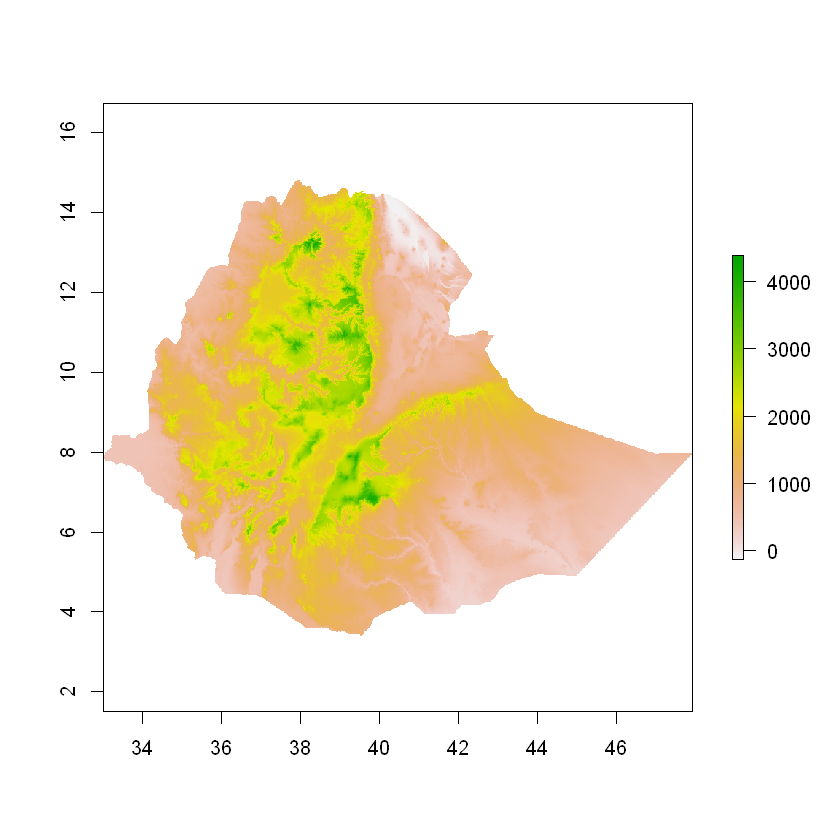

In [21]:
raster_test <- rasterFromXYZ(output_df)
plot(raster_test)